In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
root_path = os.path.abspath('./..')
sys.path.insert(0, root_path )

import itertools
import functools
from tqdm import tqdm

import pandas as pd
import numpy as np
import sklearn
import sklearn.linear_model
import sklearn.cluster
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns

import hiddensc
from hiddensc import utils, files, vis

import scanpy as sc
import scvi
import anndata

utils.set_random_seed(utils.RANDOM_SEED)
utils.print_module_versions([sc, anndata, scvi, hiddensc])
vis.visual_settings()

Global seed set to 0


Random seed set to 42
scanpy              : 1.9.3
anndata             : 0.8.0
scvi                : 0.20.3
hiddensc            : beta_25.03.23


# Load results

In [6]:
EXP_IDS = ['49', '100', '154', '211', '271', '335', '403', '475',
           '552', '633', '721', '814', '915', '1023', '1140', '1267', '1404', '1555']

performance_dfs ={}
degenes_arr = {}
degenes_dfs = {}
batch_arr = {}
perturbed_arr = {}
pred_dfs = {}

for exp_id in EXP_IDS:
    exp_id = int(exp_id)
    exp_name = f'naiveB_1900_memoryB_{exp_id:d}'
    at_results_dir = functools.partial(os.path.join, root_path, files.RESULT_DIR, exp_name)
    fname = at_results_dir('predictions.csv')
    if os.path.exists(fname):
        batch_arr[exp_name], perturbed_arr[exp_name], pred_df = files.load_predictions(at_results_dir())
        pred_dfs[exp_name] = pred_df
    fname = at_results_dir('classification_stats.csv')
    if os.path.exists(fname):
        performance_dfs[exp_name] = pd.read_csv(fname)
    fname = at_results_dir('de_genes.csv')
    if os.path.exists(fname):
        degenes_dfs[exp_name] = pd.read_csv(fname)
        degenes_arr[exp_name] = files.load_npz(fname.replace('.csv','.npz'))
    
all_performance_df = pd.concat(list(performance_dfs.values()))
vis.peek_df(all_performance_df)
all_degenes_df = pd.concat(list(degenes_dfs.values()))
vis.peek_df(all_degenes_df)

DF shape: (268, 8)
Columns: ['Dataset', 'DimReduction', 'PredictionMethod', 'AUCROC', 'AP', 'Recall', 'Precision', 'F1']


,Dataset,DimReduction,PredictionMethod,AUCROC,AP,Recall,Precision,F1
0,naiveB_1900_memoryB_49,LinearSCVI_10,Logistic,0.955,0.409,1.000,0.127,0.225
1,naiveB_1900_memoryB_49,LinearSCVI_10,SVM,0.932,0.310,1.000,0.086,0.158


DF shape: (285, 9)
Columns: ['Dataset', 'True labels', 'DimReduction', 'PredictionMethod', 'Approach', 'Precision', 'Recall', 'FDR', 'F1']


,Dataset,True labels,DimReduction,PredictionMethod,Approach,Precision,Recall,FDR,F1
0,naiveB_1900_memoryB_49,Naive B/Memory B,NaN,NaN,sample,NaN,0.000,NaN,NaN
1,naiveB_1900_memoryB_49,Naive B/Memory B,LinearSCVI_10,Logistic,LinearSCVI_10_Logistic,0.357,0.714,0.643,0.476


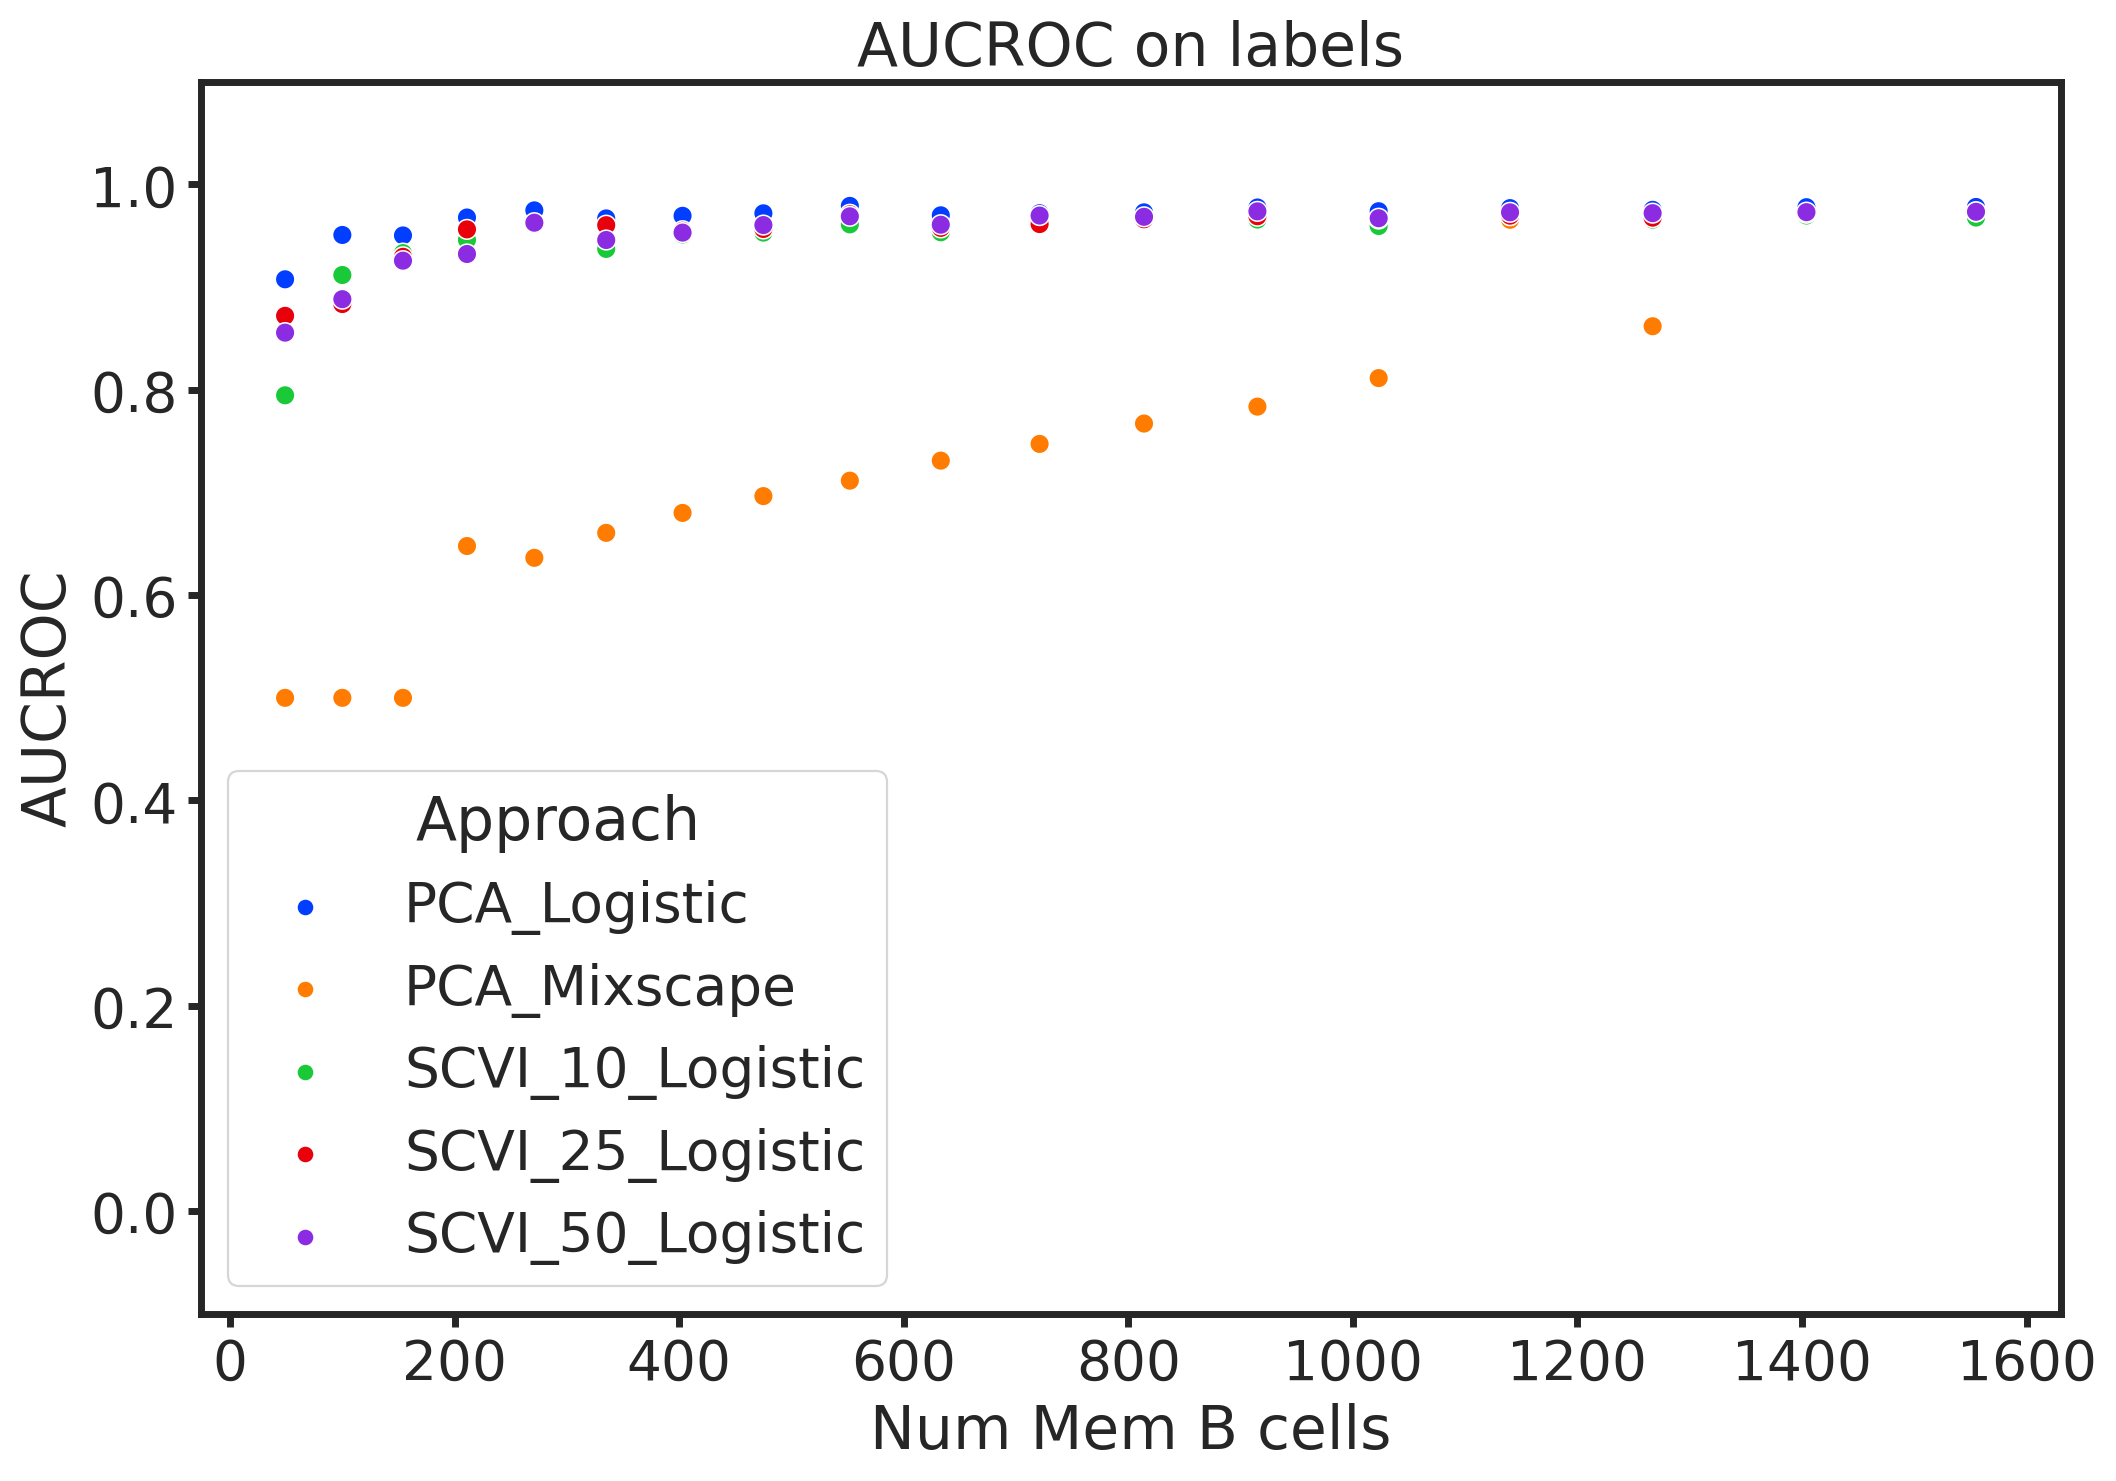

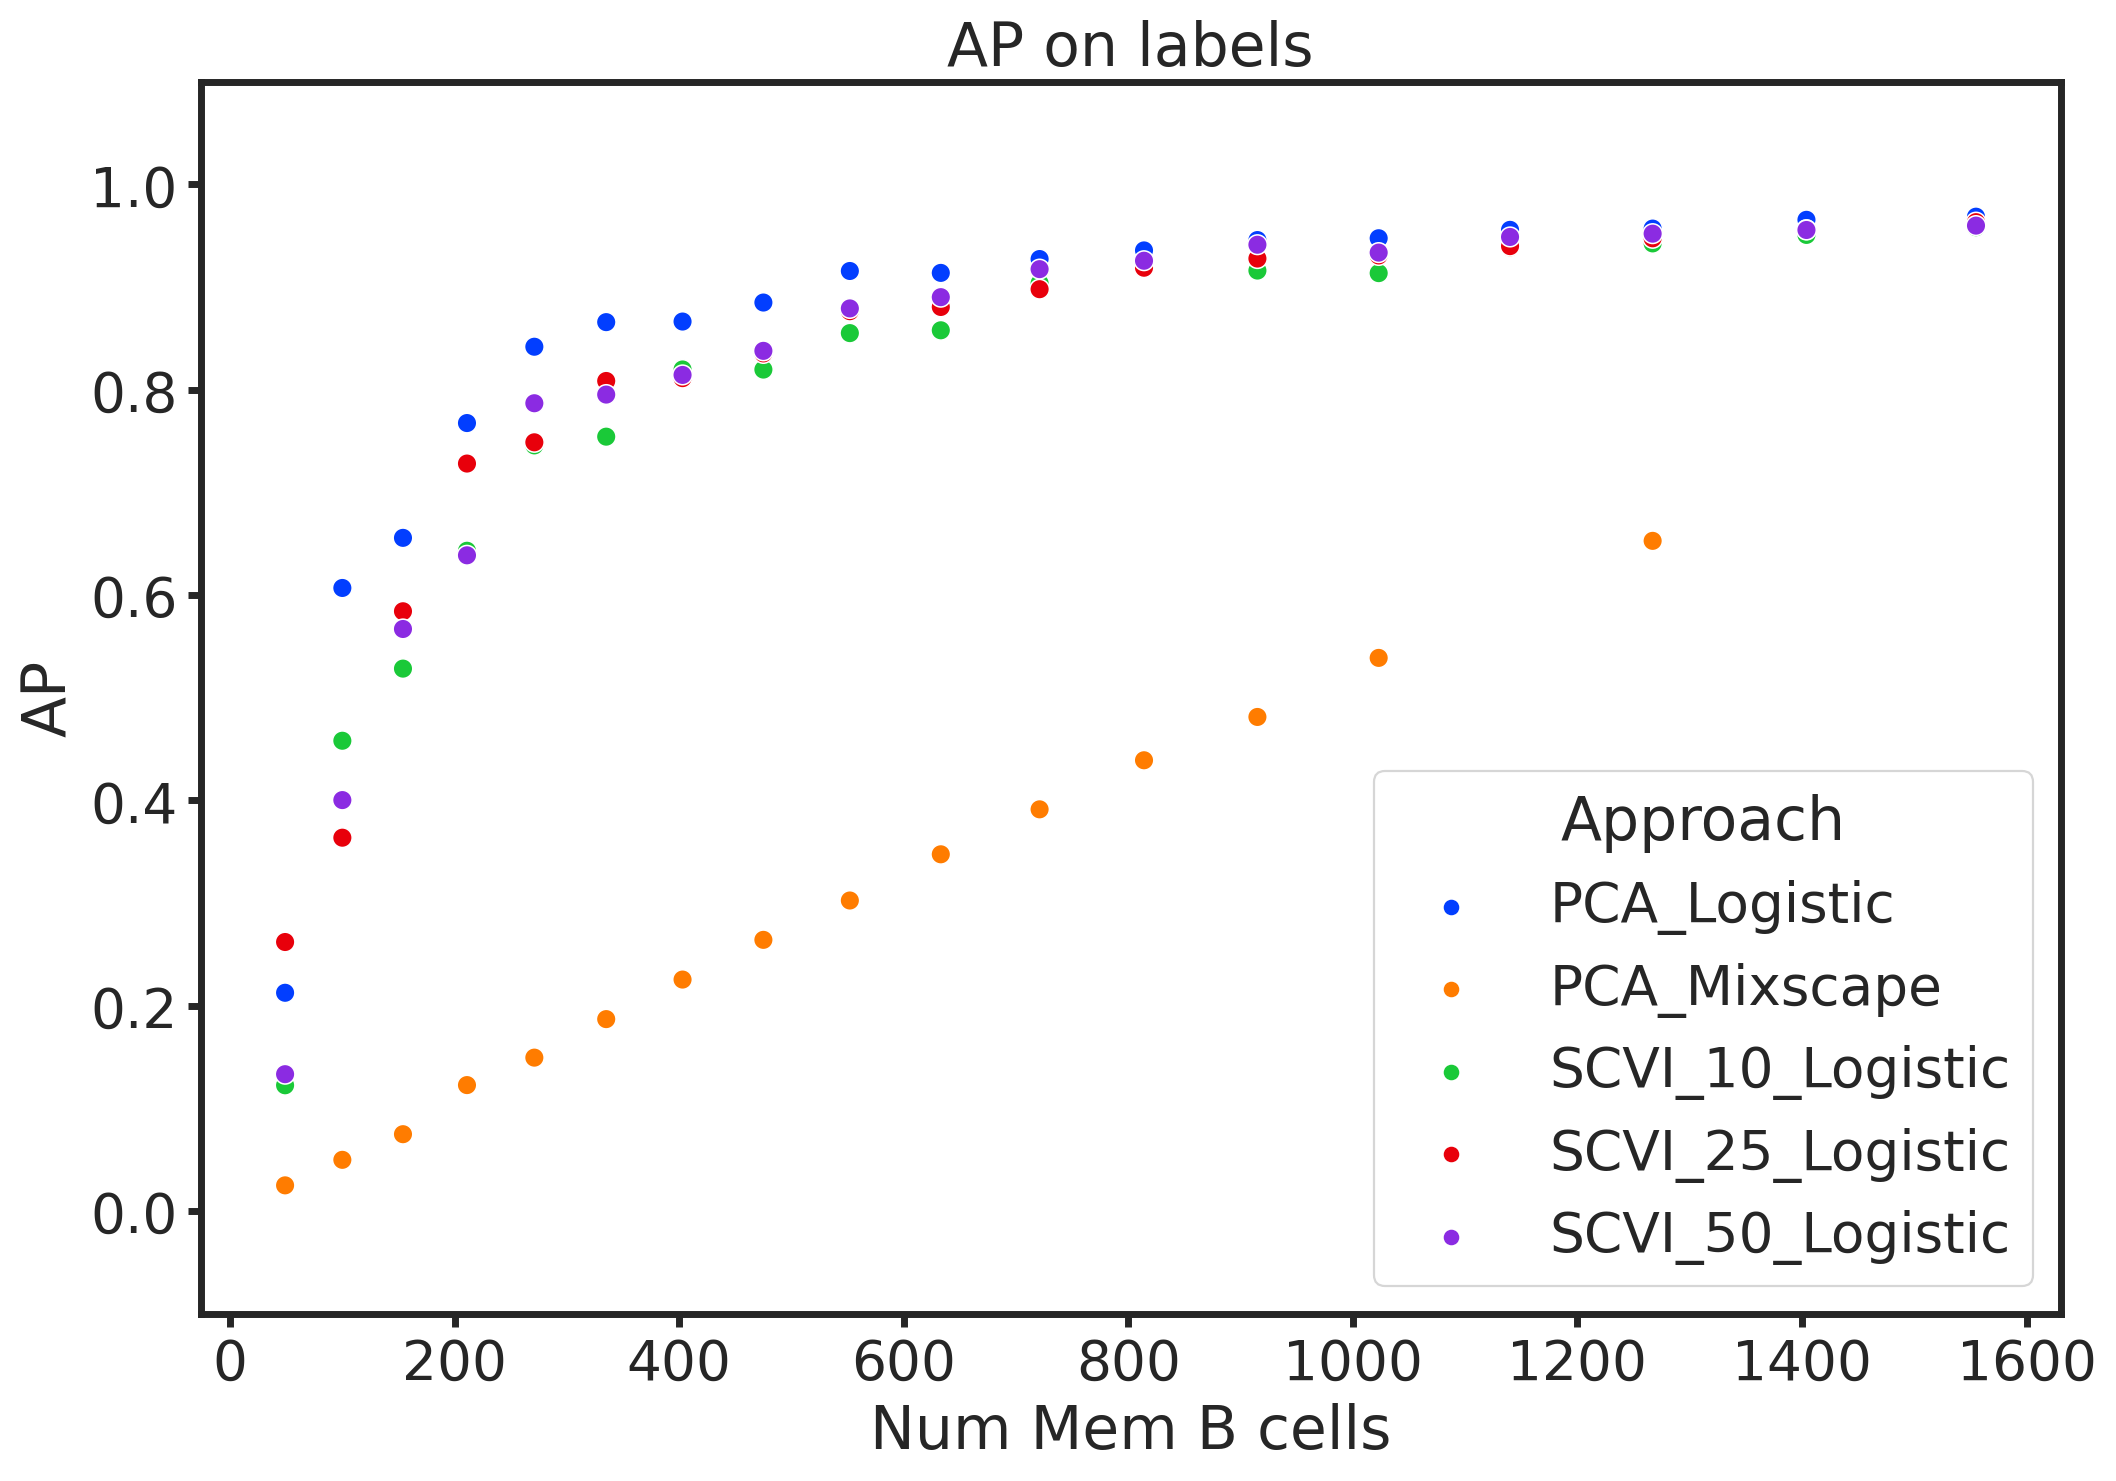

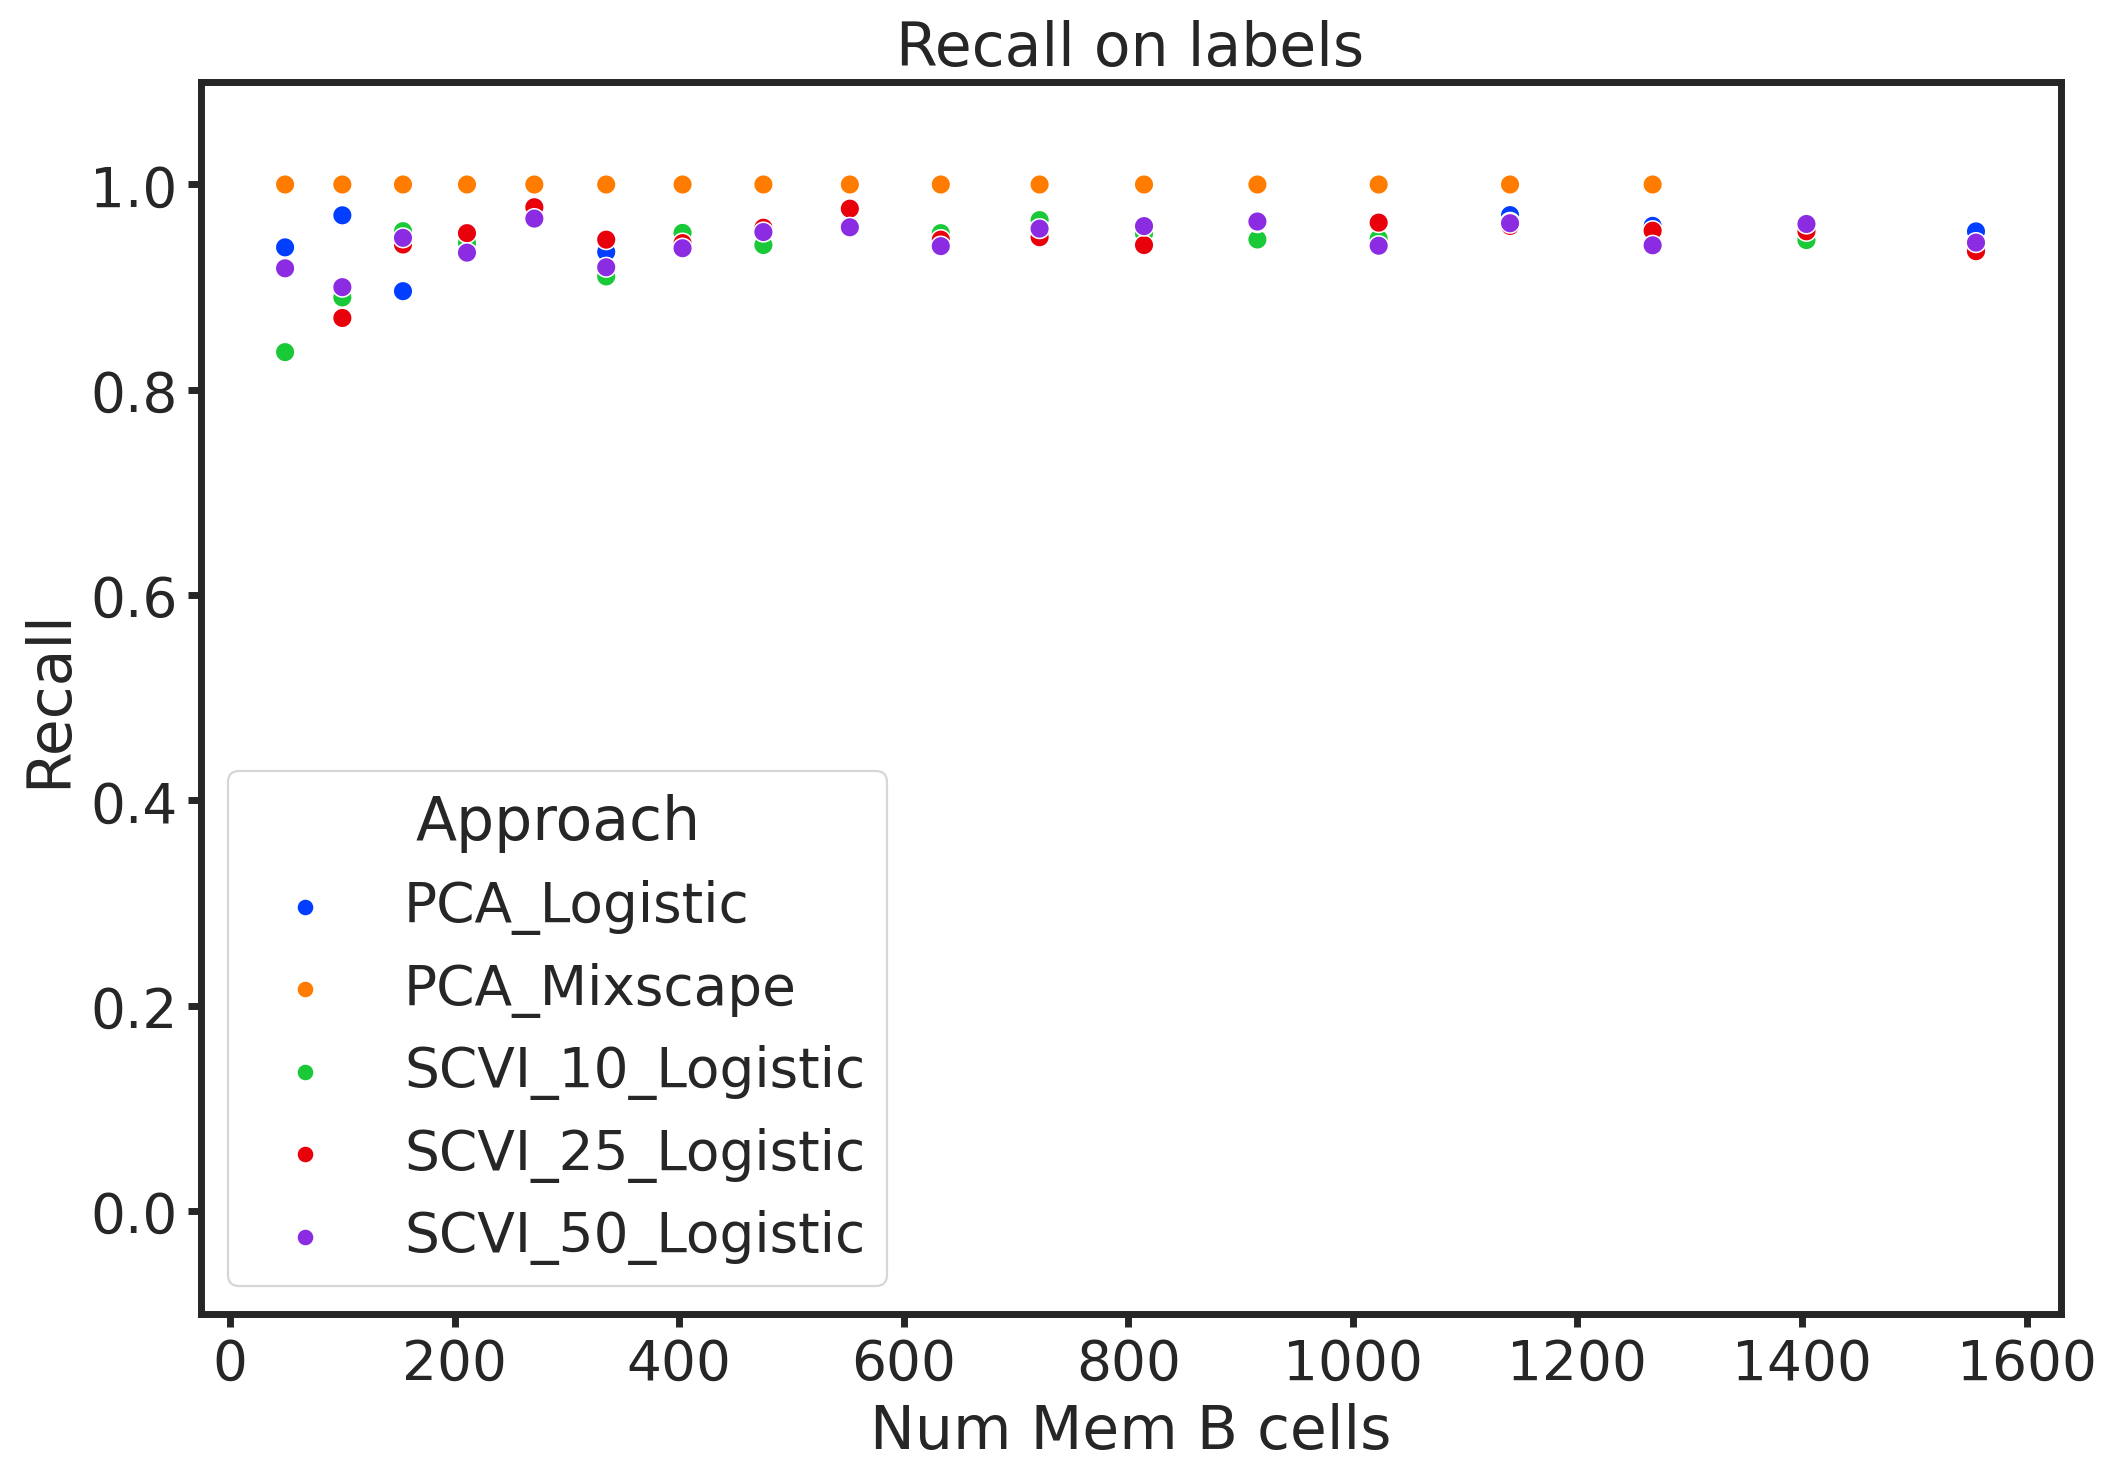

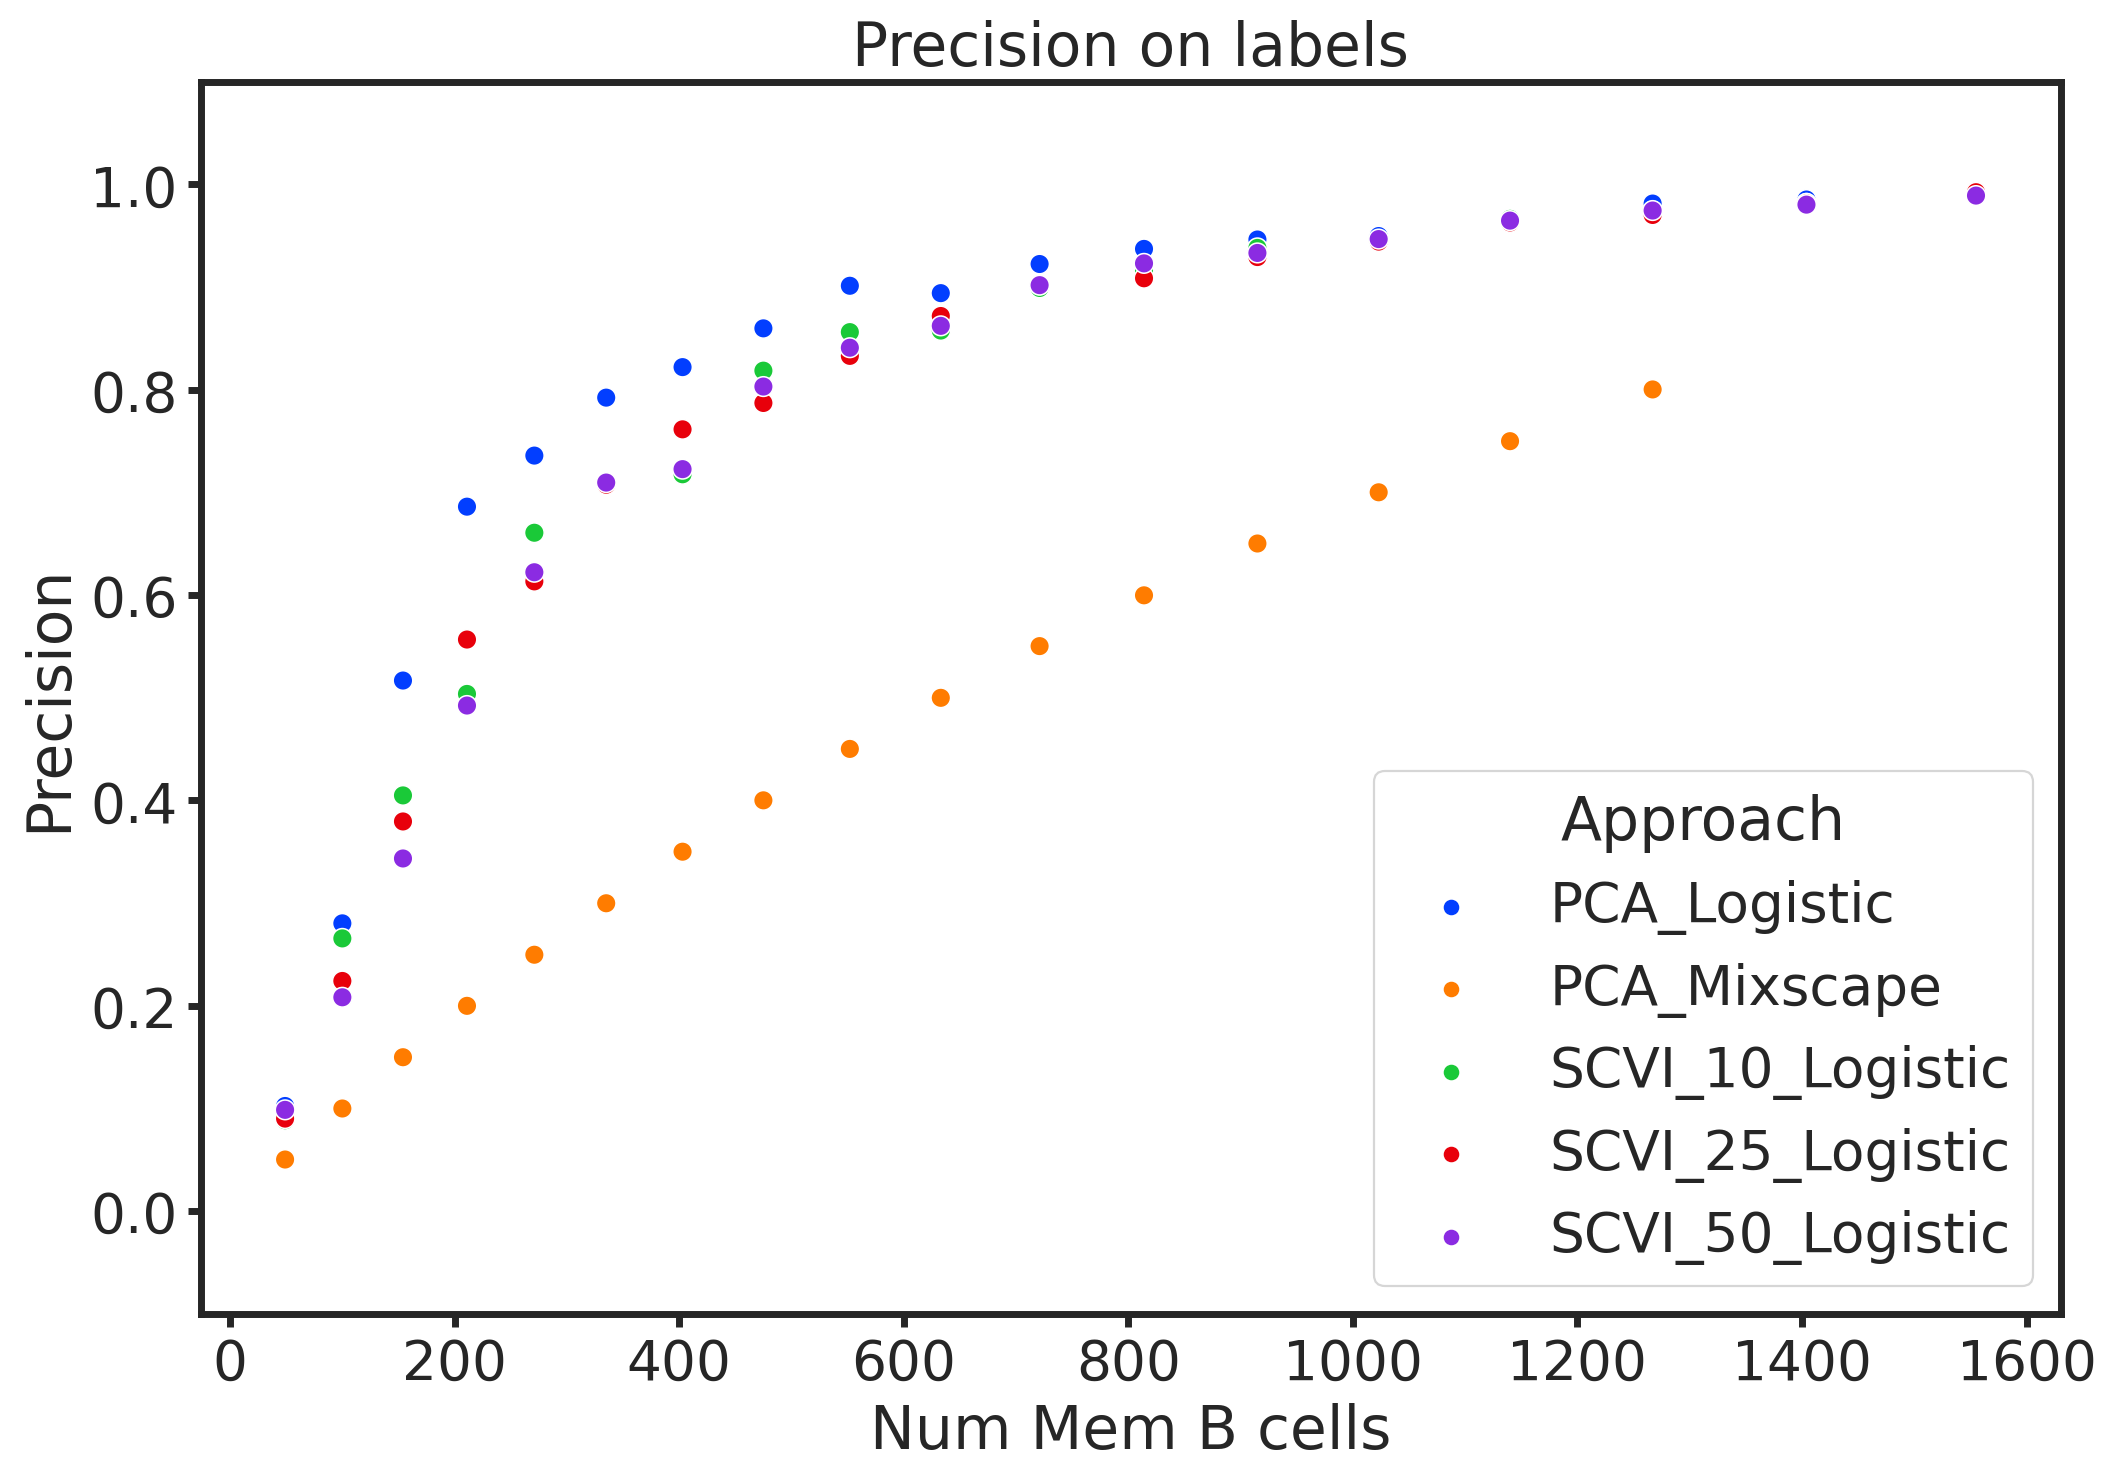

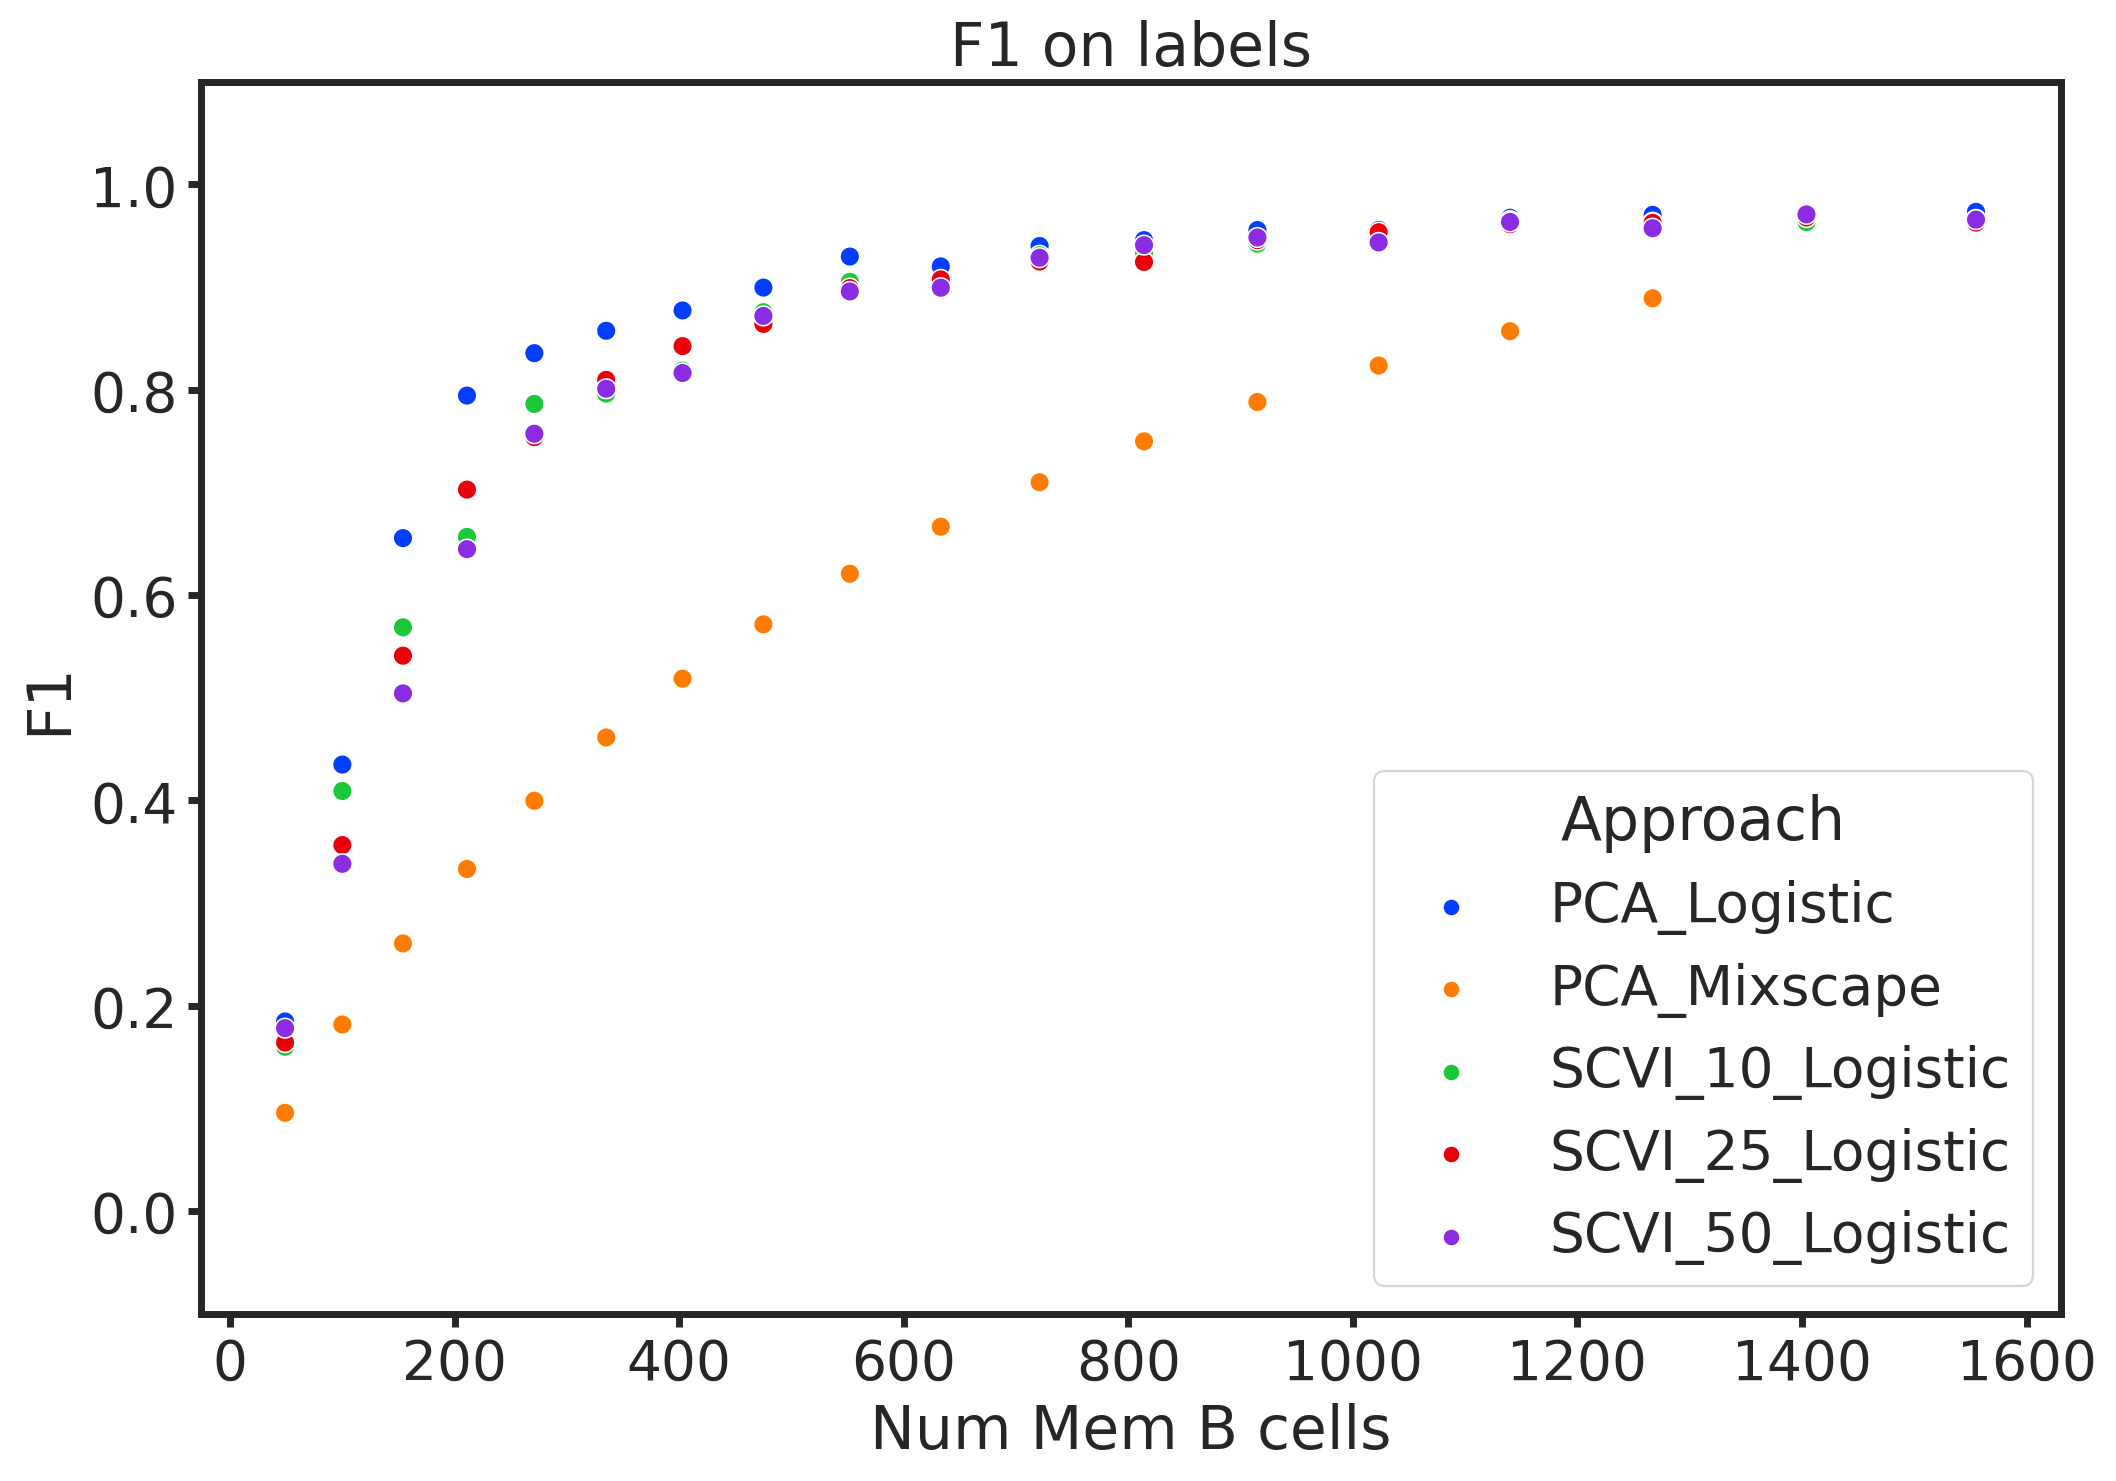

In [20]:
for metric in ['AUCROC', 'AP', 'Recall', 'Precision', 'F1']:
    methods = ['PCA_Logistic', 'PCA_Mixscape', 'SCVI_10_Logistic', 'SCVI_25_Logistic', 'SCVI_50_Logistic']
    vis_df = all_performance_df
    vis_df['Num Mem B cells'] = vis_df['Dataset'].apply(lambda x: int(x.split('_')[-1]))
    vis_df['Approach'] = vis_df['DimReduction']+'_'+vis_df['PredictionMethod']
    mask = vis_df['Approach'].isin(list(methods))
    vis_df = vis_df[mask]
    sns.scatterplot(x='Num Mem B cells', y=metric, hue='Approach', data=vis_df, s=50)
    plt.title(f'{metric} on labels')
    plt.ylim([-0.1, 1.1])
    plt.show()

In [77]:
all_performance_df

,exp,dim_reduce,method,AUCROC,AP,Recall,Precision,F1,Num Mem B cells,approach
0,naiveB_1900_memoryB_49,LinearSCVI_10,logistic,0.955360,0.408911,1.000000,0.126615,0.224771,49,LinearSCVI_10_logistic
1,naiveB_1900_memoryB_49,LinearSCVI_10,svm,0.931998,0.310097,1.000000,0.085515,0.157556,49,LinearSCVI_10_svm
2,naiveB_1900_memoryB_49,LinearSCVI_25,logistic,0.903888,0.297692,0.877551,0.124638,0.218274,49,LinearSCVI_25_logistic
3,naiveB_1900_memoryB_49,LinearSCVI_25,svm,0.879962,0.261581,0.897959,0.115789,0.205128,49,LinearSCVI_25_svm
4,naiveB_1900_memoryB_49,LinearSCVI_50,logistic,0.858969,0.221485,0.938776,0.100437,0.181460,49,LinearSCVI_50_logistic
...,...,...,...,...,...,...,...,...,...,...
9,naiveB_1900_memoryB_552,SCVI_10,svm,0.961162,0.851072,0.956522,0.855754,0.903336,552,SCVI_10_svm
10,naiveB_1900_memoryB_552,SCVI_25,logistic,0.971011,0.876594,0.976449,0.833076,0.899083,552,SCVI_25_logistic
11,naiveB_1900_memoryB_552,SCVI_25,svm,0.972482,0.879419,0.981884,0.845554,0.908634,552,SCVI_25_svm
12,naiveB_1900_memoryB_552,SCVI_50,logistic,0.968997,0.879284,0.958333,0.841017,0.895851,552,SCVI_50_logistic


/tmp/ipykernel_15769/1130992450.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vis_df['approach'] = vis_df['approach'].apply(lambda x: method_names.get(x, x))


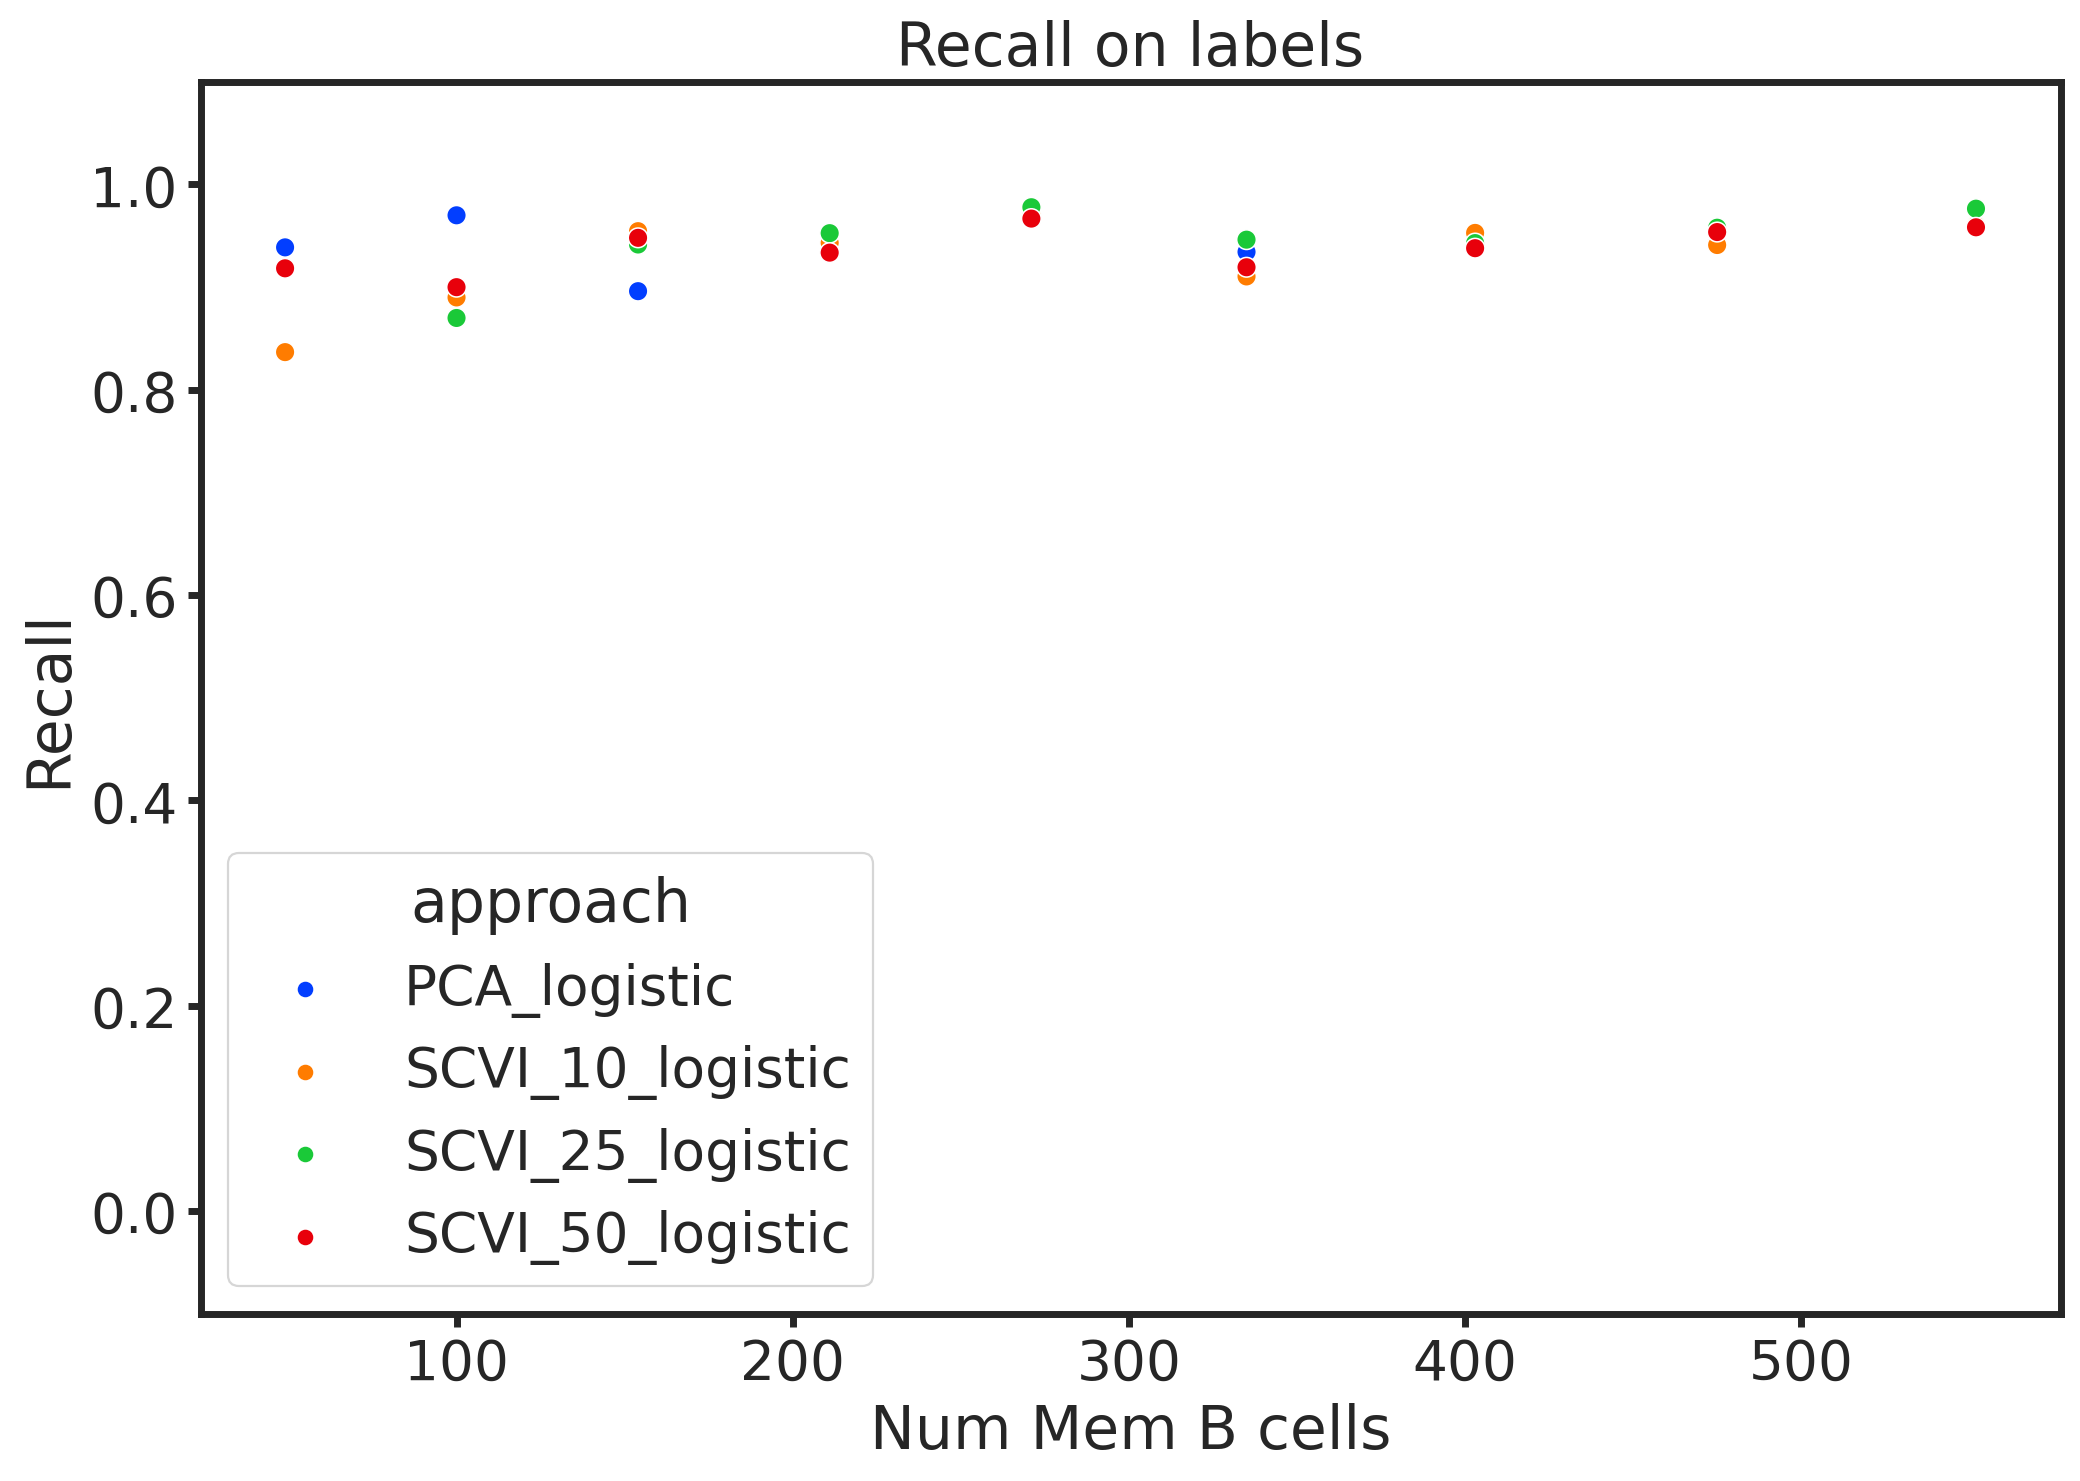

In [79]:
metric = 'Recall'
method_names = {'PCA_logistic':'PCA_logistic', 'SCVI_10_logistic':'SCVI_10_logistic',
               'SCVI_25_logistic':'SCVI_25_logistic', 'SCVI_50_logistic':'SCVI_50_logistic'}
vis_df = all_performance_df
vis_df['Num Mem B cells'] = vis_df['exp'].apply(lambda x: int(x.split('_')[-1]))
vis_df['method'] = vis_df['method'].apply(lambda x: 'logistic' if x == 'linear' else x)
vis_df['approach'] = vis_df['dim_reduce']+'_'+vis_df['method']
mask = vis_df['approach'].isin(list(method_names.keys()))
vis_df = vis_df[mask]
vis_df['approach'] = vis_df['approach'].apply(lambda x: method_names.get(x, x))
#sns.barplot(x='exp', y=metric, hue='approach', data=vis_df)
sns.scatterplot(x='Num Mem B cells', y=metric, hue='approach', data=vis_df, s=50)
plt.title('Recall on labels')
plt.ylim([-0.1, 1.1])
plt.show()
#plt.legend(labels=['a', 'b'])

/tmp/ipykernel_15769/3924420656.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vis_df['approach'] = vis_df['approach'].apply(lambda x: method_names.get(x, x))


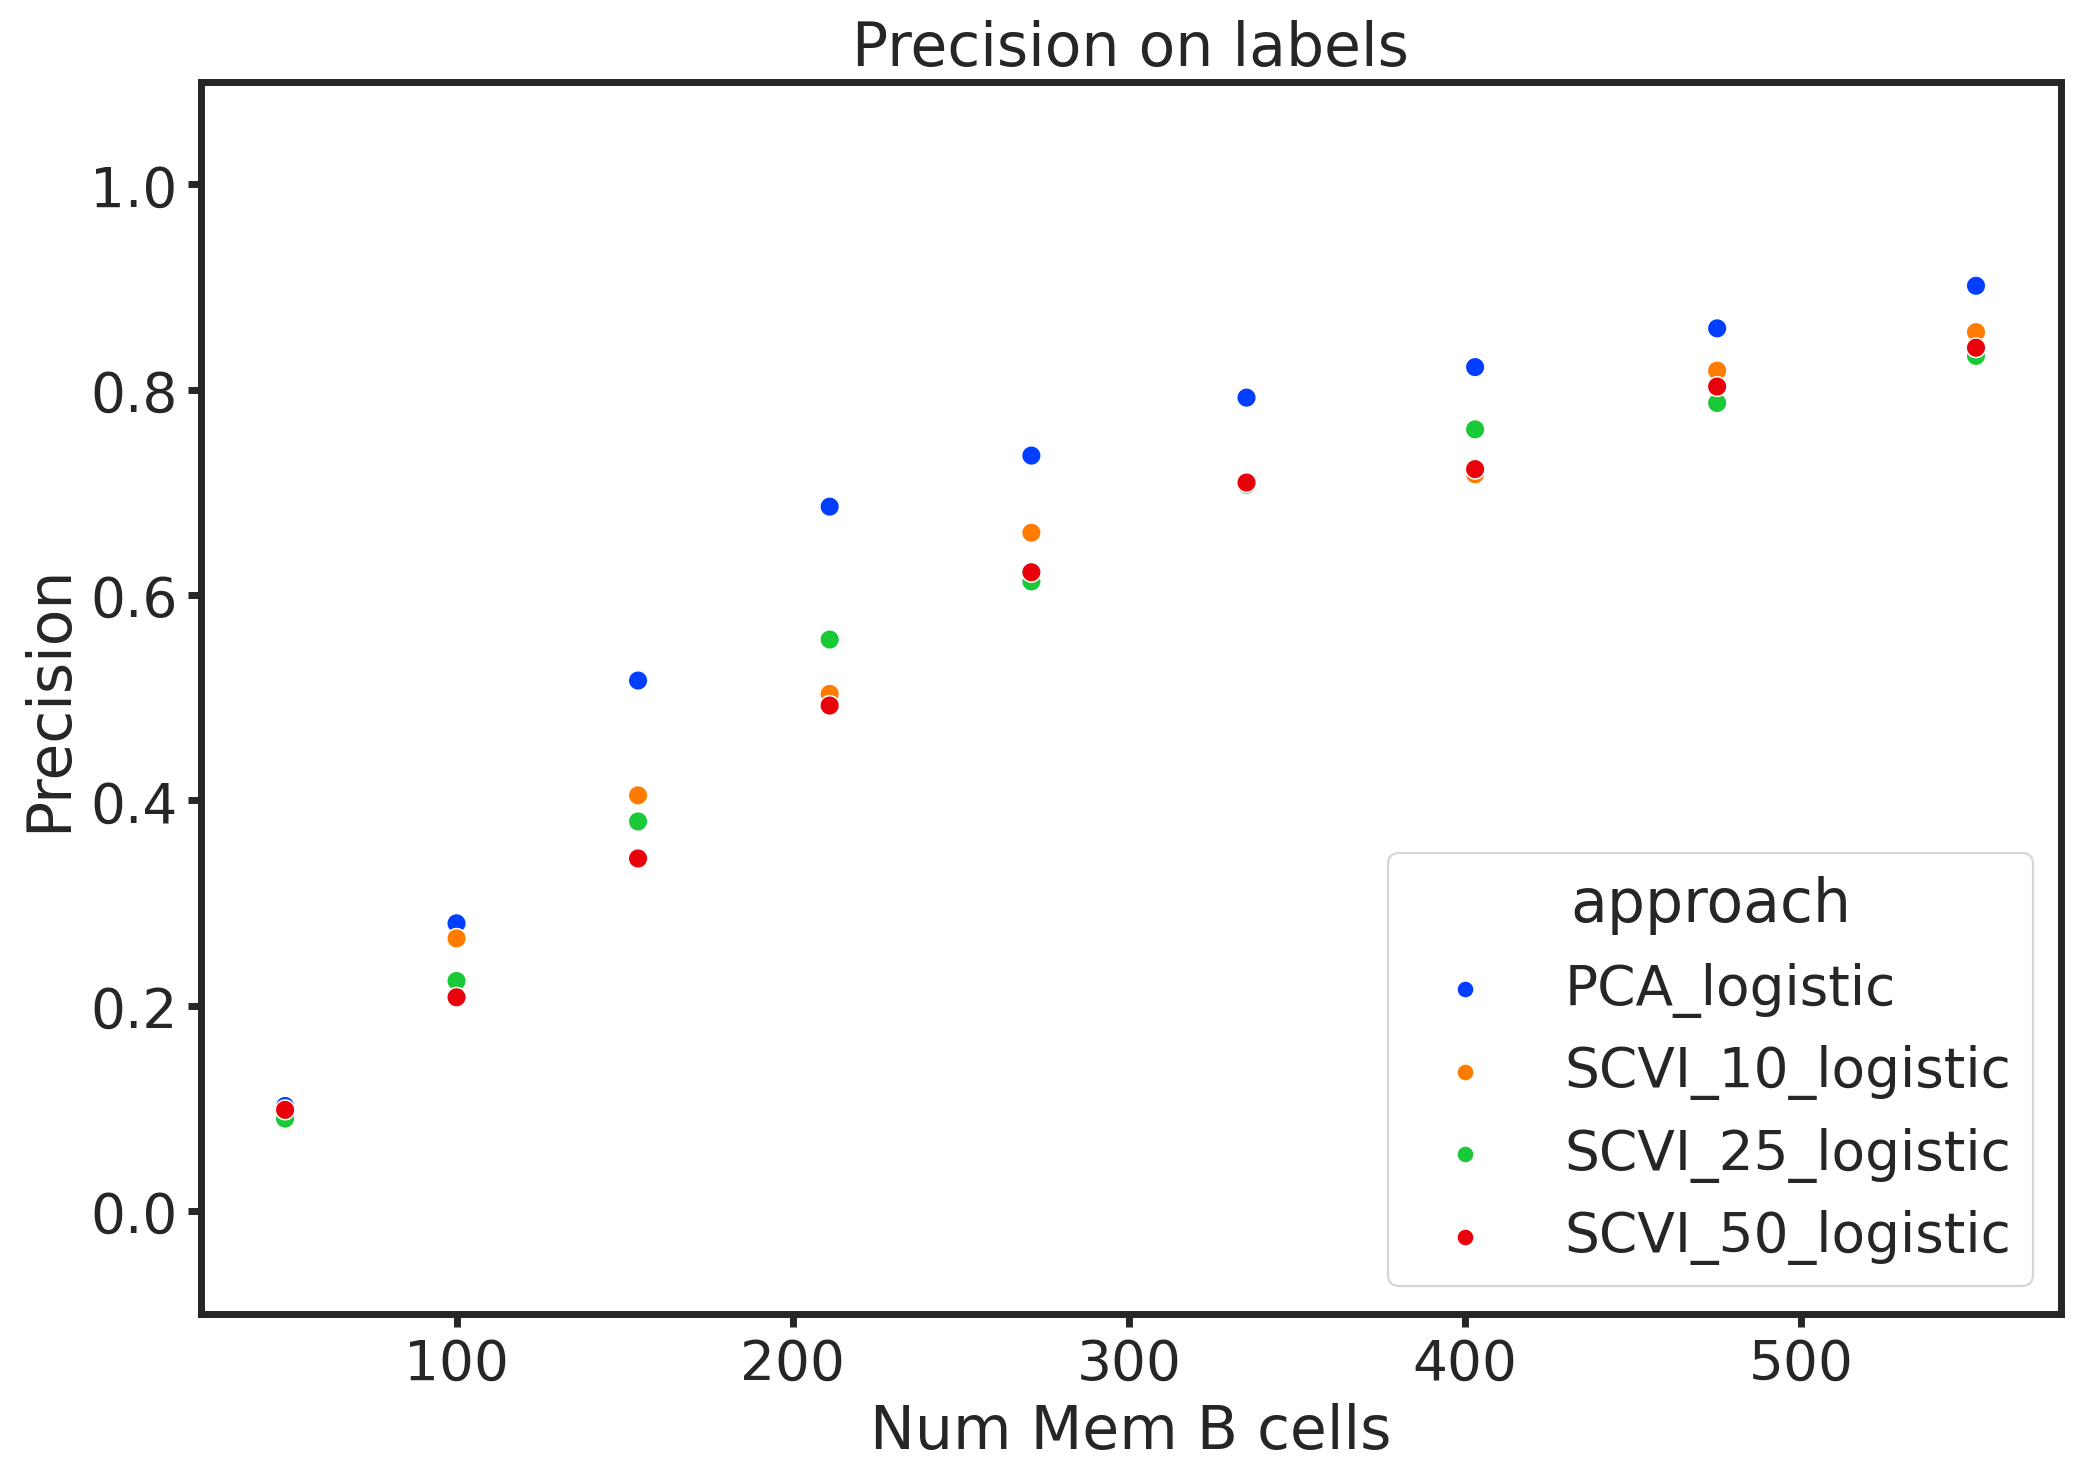

In [80]:
metric = 'Precision'
method_names = {'PCA_logistic':'PCA_logistic', 'SCVI_10_logistic':'SCVI_10_logistic',
               'SCVI_25_logistic':'SCVI_25_logistic', 'SCVI_50_logistic':'SCVI_50_logistic'}
vis_df = all_performance_df
vis_df['Num Mem B cells'] = vis_df['exp'].apply(lambda x: int(x.split('_')[-1]))
vis_df['method'] = vis_df['method'].apply(lambda x: 'logistic' if x == 'linear' else x)
vis_df['approach'] = vis_df['dim_reduce']+'_'+vis_df['method']
mask = vis_df['approach'].isin(list(method_names.keys()))
vis_df = vis_df[mask]
vis_df['approach'] = vis_df['approach'].apply(lambda x: method_names.get(x, x))
#sns.barplot(x='exp', y=metric, hue='approach', data=vis_df)
sns.scatterplot(x='Num Mem B cells', y=metric, hue='approach', data=vis_df, s=50)
plt.title('Precision on labels')
plt.ylim([-0.1, 1.1])
plt.show()
#plt.legend(labels=['a', 'b'])

In [71]:
all_degenes_df

,Unnamed: 0,exp_name,True labels,Compare_labels,info,precision,recall,fdr,f1_score,Num Mem B cells
0,0,naiveB_1900_memoryB_49,Naive B/Memory B,Control/Case,NaN,NaN,0.000000,NaN,NaN,49
1,1,naiveB_1900_memoryB_49,Naive B/Memory B,Refined labels,LinearSCVI_10_linear,0.357143,0.714286,0.642857,0.476190,49
2,2,naiveB_1900_memoryB_49,Naive B/Memory B,Refined labels,LinearSCVI_10_svm,0.200000,0.214286,0.800000,0.206897,49
3,3,naiveB_1900_memoryB_49,Naive B/Memory B,Refined labels,LinearSCVI_25_linear,0.642857,0.642857,0.357143,0.642857,49
4,4,naiveB_1900_memoryB_49,Naive B/Memory B,Refined labels,LinearSCVI_25_svm,0.600000,0.428571,0.400000,0.500000,49
...,...,...,...,...,...,...,...,...,...,...
10,10,naiveB_1900_memoryB_552,Naive B/Memory B,Refined labels,SCVI_10_svm,0.915058,0.922179,0.084942,0.918605,552
11,11,naiveB_1900_memoryB_552,Naive B/Memory B,Refined labels,SCVI_25_linear,0.938017,0.883268,0.061983,0.909820,552
12,12,naiveB_1900_memoryB_552,Naive B/Memory B,Refined labels,SCVI_25_svm,0.936000,0.910506,0.064000,0.923077,552
13,13,naiveB_1900_memoryB_552,Naive B/Memory B,Refined labels,SCVI_50_linear,0.927419,0.894942,0.072581,0.910891,552


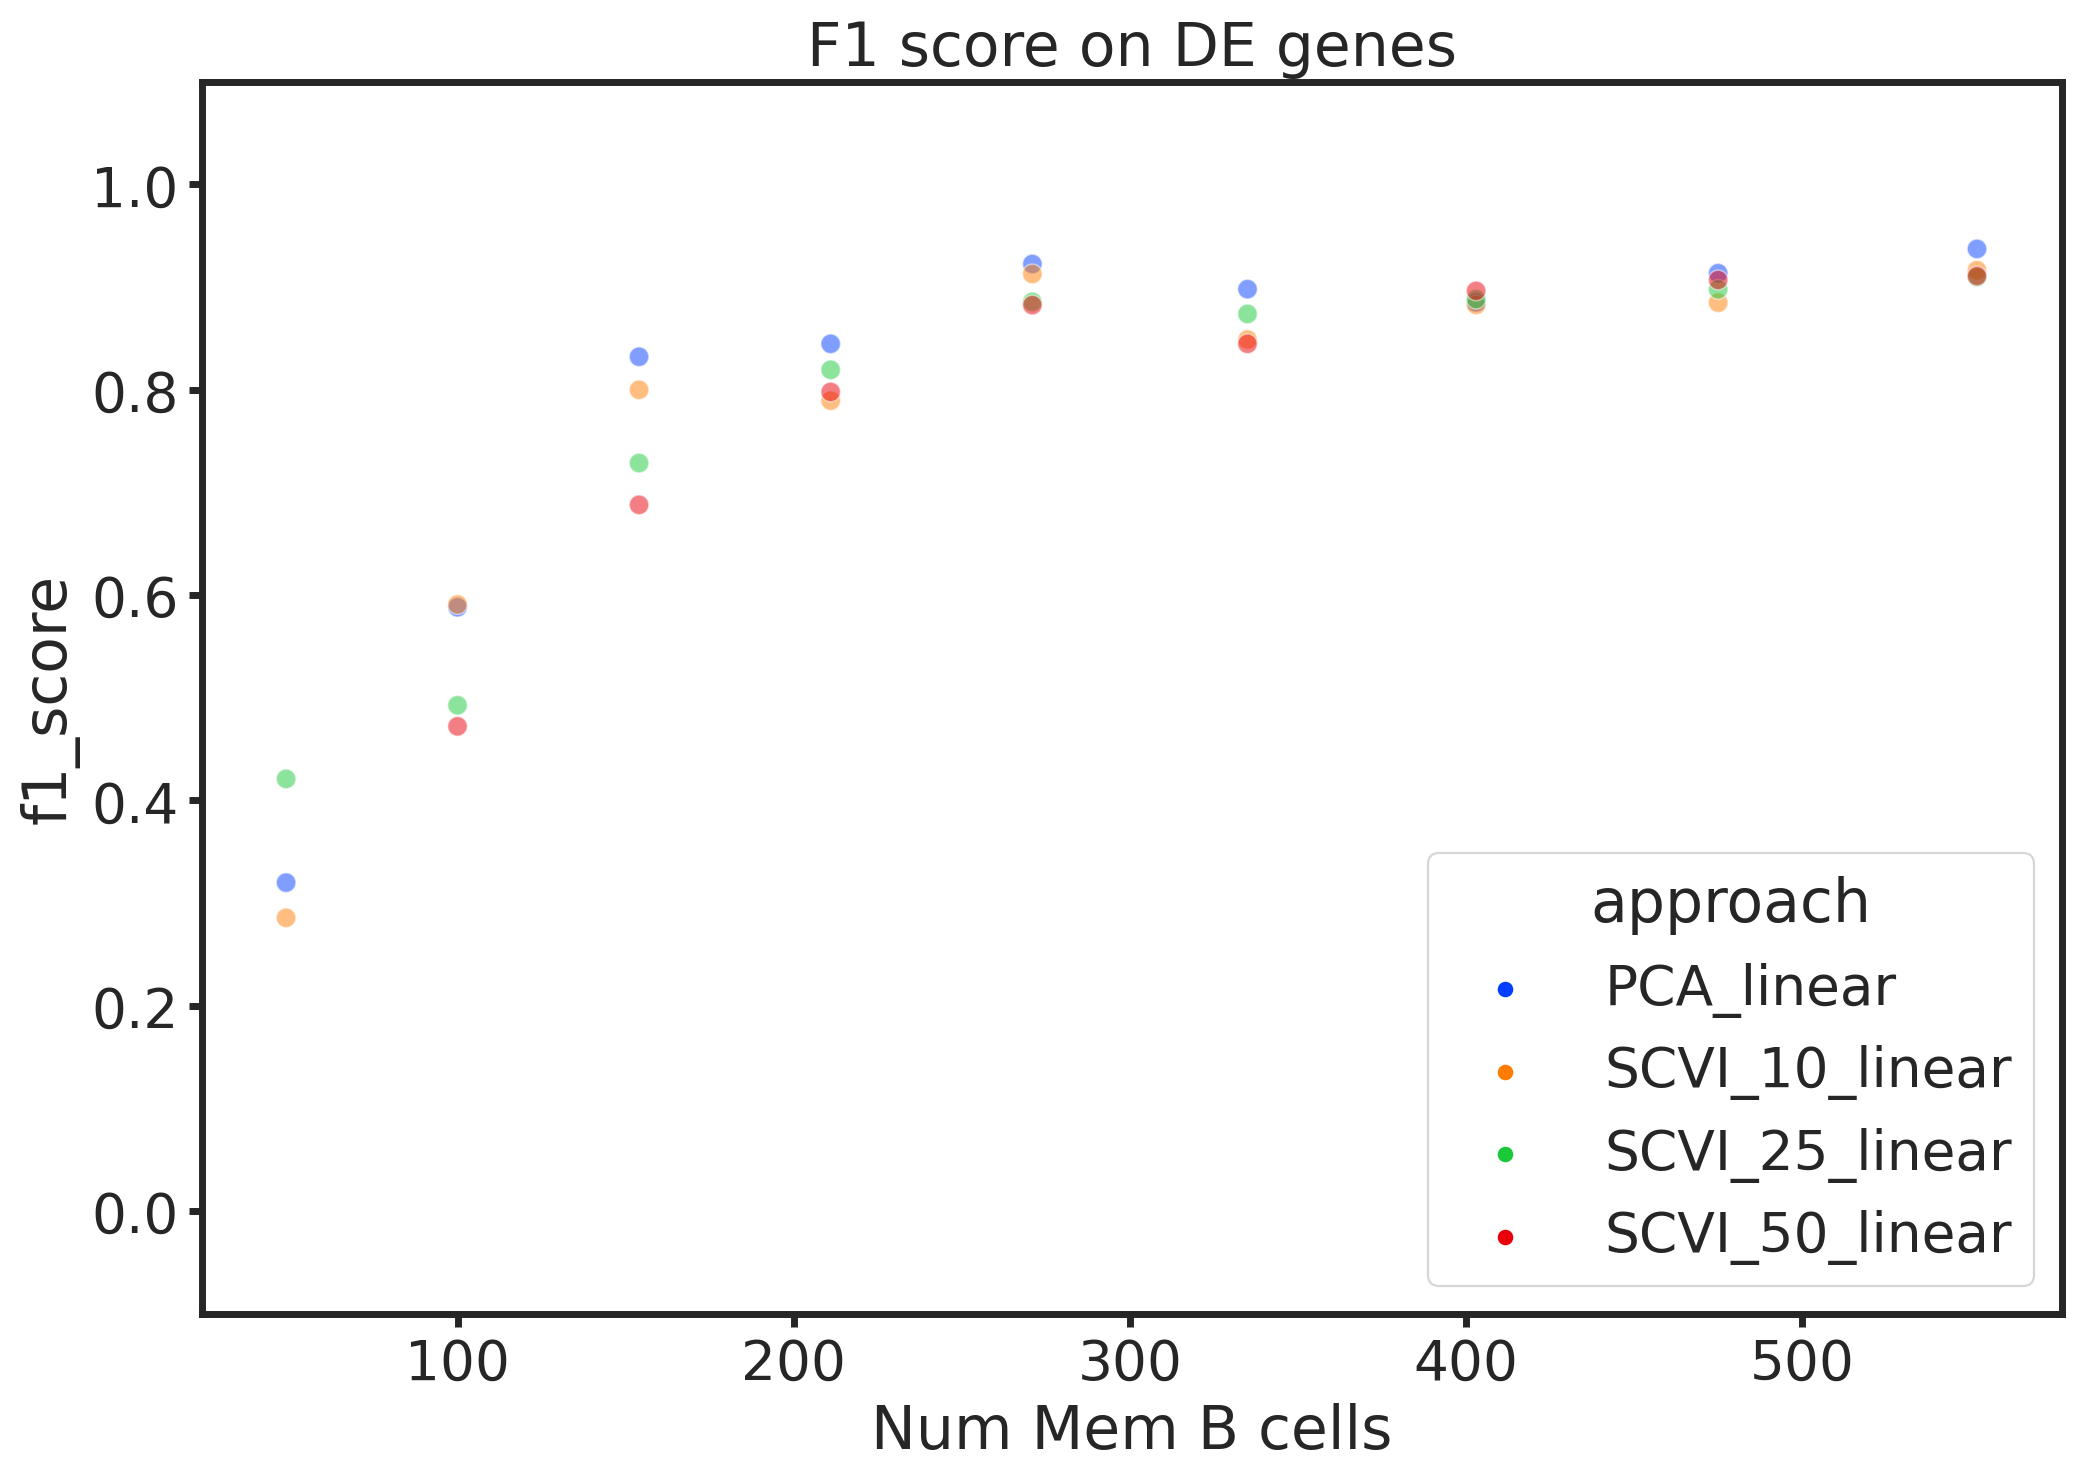

In [75]:
metric = 'f1_score'
method_names = {'PCA_linear':'PCA_logistic', 'SCVI_10_linear':'SCVI_10_logistic',
               'SCVI_25_linear':'SCVI_25_logistic', 'SCVI_50_linear':'SCVI_50_logistic',
               np.NaN:'original labels'}
vis_df = all_degenes_df
vis_df['Num Mem B cells'] = vis_df['exp_name'].apply(lambda x: int(x.split('_')[-1]))
#vis_df['info'] = vis_df['info'].apply(lambda x: 'logistic' if x == 'linear' else x)
#vis_df['approach'] = vis_df['dim_reduce']+'_'+vis_df['method']
mask = vis_df['info'].isin(list(method_names.keys()))
vis_df = vis_df[mask]
#vis_df['approach'] = vis_df['approach'].apply(lambda x: method_names.get(x, x))
#sns.barplot(x='exp', y=metric, hue='approach', data=vis_df)
sns.scatterplot(x='Num Mem B cells', y=metric, hue='info', data=vis_df, s=50, alpha=0.5)
plt.title('F1 score on DE genes')
plt.legend(title='approach')
plt.ylim([-0.1, 1.1])
plt.show()